In [168]:
import numpy as np
import pandas as pd
import time
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import joblib

import warnings
warnings.filterwarnings('ignore')

## Загрузка датасета

In [175]:
def get_train_test():

    df = pd.read_csv('train_test.csv', sep=';', encoding='cp1251')
    
    del_columns=['inn', 'дата_начала_полномочий_руководителя', 'Даты_внесения_соучредителей', 
                       'Дата_регистрации', 'История_смены_сооучредителей',
                       'date_open_pc', 'month_date_open_pc']
    
    print('Уникальных ИНН', df.inn.unique().shape[0])
    df = df.drop(del_columns, axis=1)
    
    return df

In [170]:
float_columns = ['Количество_компаний_с_аналогичным_директором_в_том_же_регионе',
                 'Количество_компаний,_зарегистрированных_на_адресе_регистрации_Организации_по_данным_сайта_ФНС',
                 'Количество_видов_деятельности_у_Клиента',
                 'размер_уставного_капитал_ЮЛ',
                 'Чистая_прибыль_(или_убыток)_компании',
                 'Пассивы_всего',
                 'Количество_соучредителей',
                 'Количество_филиалов',
                 'Выручка_компании_(млн,_руб)',
                 'Участие_в_госконтрактах_(количество)',
                 'Сумма_налога',
                 '7_-_массовый_контактный_телефон:_в_заявке_указан_телефон,_на_который_зарегистрировано_более_Х_компаний_(кроме_компаний-агентов)',
                 '8_-_Количество_компаний_с_аналогичным_директором',
                 '8_-_Количество_компаний_с_аналогичным_директором_в_том_же_регионе',
                 '25_-_Государственные_заказы_и_контракты_Приняла_участие_(количество)',
                 '25_-_Коммерческие_заказы_и_контракты_Количество_заключенных_контрактов',
                 'is_credit']

In [171]:
pd.set_option('display.max_columns', 100)
print(df.shape)
df.head()

(56645, 27)


,org_type,target,Количество_компаний_с_аналогичным_директором_в_том_же_регионе,"Количество_компаний,_зарегистрированных_на_адресе_регистрации_Организации_по_данным_сайта_ФНС",Количество_видов_деятельности_у_Клиента,код_основного_оквэд,Субъект_местонахождения,размер_уставного_капитал_ЮЛ,Чистая_прибыль_(или_убыток)_компании,Отчетный_период_(год),Пассивы_всего,Количество_соучредителей,Количество_филиалов,Численность_компании,"Выручка_компании_(млн,_руб)",Участие_в_госконтрактах_(количество),Участие_в_госконтрактах_(год),Сумма_налога,ОПФ_Организации,"7_-_массовый_контактный_телефон:_в_заявке_указан_телефон,_на_который_зарегистрировано_более_Х_компаний_(кроме_компаний-агентов)",8_-_Количество_компаний_с_аналогичным_директором,8_-_Количество_компаний_с_аналогичным_директором_в_том_же_регионе,25_-_Государственные_заказы_и_контракты_Приняла_участие_(количество),25_-_Коммерческие_заказы_и_контракты_Количество_заключенных_контрактов,Индекс_финансового_риска_описание,Индекс_должной_осмотрительности_описание,is_credit
0,ЮЛ,0,2.0,1.0,10.0,NaN,NaN,10000.0,NaN,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,65-Общества с ограниченной ответственностью,1.0,2.0,2.0,NaN,NaN,Средний риск,Средний риск,0.0
1,ЮЛ,0,3.0,3.0,18.0,NaN,NaN,19600.0,7445830.0,2017.0,34270600.0,3.0,0.0,16 .. 50,30.5,NaN,NaN,NaN,65-Общества с ограниченной ответственностью,29.0,3.0,3.0,2.0,NaN,Низкий риск,Средний риск,0.0
2,ИП,0,0.0,NaN,5.0,NaN,AJ,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,50102-Индивидуальные предприниматели,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0
3,ЮЛ,0,2.0,11.0,3.0,NaN,NaN,260000.0,3784950.0,2017.0,1063230.0,2.0,0.0,16 .. 50,44.4,0.0,2017.0,NaN,65-Общества с ограниченной ответственностью,1.0,2.0,2.0,0.0,0.0,Низкий риск,Низкий риск,0.0
4,ЮЛ,0,1.0,1.0,25.0,NaN,NaN,10000.0,NaN,NaN,NaN,2.0,0.0,NaN,NaN,NaN,NaN,NaN,65-Общества с ограниченной ответственностью,0.0,1.0,1.0,NaN,NaN,Расчет индекса не осуществляется,Средний риск,0.0


In [116]:
#df = df.drop([
#             'Субъект_местонахождения'
#             ], axis=1)

## 1. Логистическая регрессия

## Препроцессинг

### Все изменения выборки можно проводить только на train, запоминать, каким образом менялись значения, затем применять к тестовой и валидационной выборке

In [ ]:
df = get_train_test()

In [172]:
# Для кросс-валидации применим к train-test
#Обрежем числовые предикторы по 1 и 99 квантилю 
float_1_quantile = {}
float_99_quantile = {}

for col in float_columns:
    value_1 = df[col].dropna().quantile([0.01]).values[0]
    value_99 = df[col].dropna().quantile([0.99]).values[0]
    
    df.loc[lambda x: x[col]>value_99, col] = value_99
    df.loc[lambda x: x[col]<value_1, col] = value_1
    
    #Запомним значения квантилей для препроцессинга отложенной выборки
    float_99_quantile[col] = value_99  
    float_1_quantile[col] = value_1  

# Заполним пропуска модой, one-hot encoding
df = df.fillna(df.mode().iloc[0])
df = pd.get_dummies(df, drop_first=True)

X_train = df.drop('target', axis=1)
y_train = df['target']

scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)


## Подбор параметров с кросс-валидацией

In [177]:
parameters = {
    'max_iter': [1000],
    'C': [1, 10, 100],
    'penalty' : ['l2'],
    'random_state': [12],
    'class_weight': ['balanced'],
    'solver'  : ['liblinear', 'saga', 'sag', 'newton-cg', 'lbfgs'],
}

logreg = LogisticRegression()
clf = GridSearchCV(estimator= logreg,           
                   param_grid = parameters, 
                   scoring='roc_auc',      
                   cv=10,
                   verbose=1)  

clf.fit(X_train,y_train)

Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  4.4min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_iter': [1000], 'C': [1, 10, 100], 'penalty': ['l2'], 'random_state': [12], 'class_weight': ['balanced'], 'solver': ['liblinear', 'saga', 'sag', 'newton-cg', 'lbfgs']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [237]:
print(clf.best_params_)
print(clf.best_score_)

{'C': 1, 'class_weight': 'balanced', 'max_iter': 1000, 'penalty': 'l2', 'random_state': 12, 'solver': 'saga'}
0.7094196012810122


In [186]:
print('Mean roc_auc', clf.cv_results_['mean_test_score'].mean())
print('Std', clf.cv_results_['std_test_score'].mean())

Mean roc_auc 0.7094113735784564
Std 0.01705988230475435


# 2. Бустинг LightGBM

### Препроцессинг - категориальные признаки

Распределение по квантилям можно не смещать для деревьев

In [239]:
df = get_train_test()

Уникальных ИНН 55762


In [240]:
cat_feats = []

for col in df.dtypes[lambda x: x=='object'].index:
    df[col] = df[col].astype('category')
    cat_feats.append(col)
    
cat_feats

['org_type',
 'код_основного_оквэд',
 'Субъект_местонахождения',
 'Численность_компании',
 'ОПФ_Организации',
 'Индекс_финансового_риска_описание',
 'Индекс_должной_осмотрительности_описание']

## Подбор параметров с кросс-валидацией

In [243]:
start_time = time.time()

indexes_of_categories = [df.columns.get_loc(col) for col in cat_feats]

gkf = KFold(n_splits=5, shuffle=True, random_state=12)\
         .split(df.drop('target',axis=1), df['target'])

param_grid = {
    'n_estimators':[400,500,700,800,1000],
    'max_depth': [5,6,7],
    'num_leaves': [31, 63, 127],
    'min_data_in_leaf': [50, 100, 300, 400, 500],
    'lambda_l1': [1, 10, 100],
    'lambda_l2': [1, 10, 100]
    }


model = lgb.LGBMClassifier(boosting_type='gbdt', 
                                   is_unbalance=True,
                                   objective='binary', 
                                   learning_rate=0.01, 
                                   metric='auc',
                                   categorical_feature=indexes_of_categories)

#early_stopping_rounds = 25,

clf_lgb = RandomizedSearchCV(model, param_grid, verbose = 1, cv=gkf, n_iter=100)

clf_lgb.fit(df.drop('target',axis=1), df['target'], verbose=2)


print('время', time.time() - start_time)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed: 47.0min finished


время 2831.471313714981


In [242]:
print(clf_lgb.best_params_)
print(clf_lgb.best_score_)

{'num_leaves': 31, 'n_estimators': 700, 'min_data_in_leaf': 50, 'max_depth': 7, 'lambda_l2': 1, 'lambda_l1': 1}
0.7219878188719216


Сравнение алгоритмов по roc_auc: LogReg 0.709 < LightGBM 0.72     
LightGBM показал лучший результат

# 3. Построение модели на лучшем алгоритме

In [265]:
df = get_train_test()

Уникальных ИНН 55762


In [266]:
cat_feats = []

for col in df.dtypes[lambda x: x=='object'].index:
    df[col] = df[col].astype('category')
    cat_feats.append(col)
    
cat_feats

['org_type',
 'код_основного_оквэд',
 'Субъект_местонахождения',
 'Численность_компании',
 'ОПФ_Организации',
 'Индекс_финансового_риска_описание',
 'Индекс_должной_осмотрительности_описание']

## Кросс-валидация на 10 фолдах

In [267]:
grid_params = {'boosting_type':'gbdt', 
               'is_unbalance':True,
               'objective':'binary', 
                'learning_rate':0.01, 
                'metric':'auc',
                'num_leaves': 31, 
                'n_estimators': 800, 
                'min_data_in_leaf': 50, 
                'max_depth': 7, 
                'lambda_l2': 1, 
                'lambda_l1': 1,
                'feature_fraction':0.7,
                'bagging_fraction':0.7}

In [268]:
train = lgb.Dataset(data=df.drop('target', axis=1),
                    label=df['target'],
                    categorical_feature=cat_feats,
                    free_raw_data = False) 

lgb_cv = lgb.cv(
              params = grid_params,
              train_set = train,
              num_boost_round=800,
              stratified=True,
              nfold = 10,
              verbose_eval=50,
              metrics='auc',
              early_stopping_rounds=50)

[50]	cv_agg's auc: 0.736721 + 0.0102481
[100]	cv_agg's auc: 0.738254 + 0.0102383
[150]	cv_agg's auc: 0.740626 + 0.00999729
[200]	cv_agg's auc: 0.741903 + 0.00982519
[250]	cv_agg's auc: 0.742814 + 0.0100684
[300]	cv_agg's auc: 0.743376 + 0.00952679
[350]	cv_agg's auc: 0.744073 + 0.00937259
[400]	cv_agg's auc: 0.744299 + 0.0091502
[450]	cv_agg's auc: 0.744395 + 0.00901185
[500]	cv_agg's auc: 0.745235 + 0.00918651
[550]	cv_agg's auc: 0.745763 + 0.00903554
[600]	cv_agg's auc: 0.745812 + 0.00904486
[650]	cv_agg's auc: 0.74616 + 0.00927155
[700]	cv_agg's auc: 0.74624 + 0.00943473
[750]	cv_agg's auc: 0.746164 + 0.0093544


In [269]:
print('mean:', lgb_cv['auc-mean'][-1])
print('std:', lgb_cv['auc-stdv'][-1])

mean: 0.7463145867406522
std: 0.009374192514306273


## Обучение итоговой модели

In [261]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', axis=1), 
                                                    df['target'],
                                                    shuffle=True,
                                                    random_state=12,
                                                    stratify=df['target'], 
                                                    test_size=0.2)

train = lgb.Dataset(data=X_train,
                    label=y_train,
                    categorical_feature=cat_feats,
                    free_raw_data = False) 

test = lgb.Dataset(data=X_test,
                    label=y_test,
                    categorical_feature=cat_feats,
                    free_raw_data = False) 

In [253]:
# Возьмем лучшие параметры от кросс-валидации

model = lgb.train(grid_params,
                   train_set=train,
                   valid_sets=[train,test],
                   categorical_feature=cat_feats,
                   early_stopping_rounds=120,
                   verbose_eval=50
                  )

Training until validation scores don't improve for 120 rounds.
[50]	training's auc: 0.742847	valid_1's auc: 0.730157
[100]	training's auc: 0.749245	valid_1's auc: 0.734106
[150]	training's auc: 0.75585	valid_1's auc: 0.740184
[200]	training's auc: 0.762083	valid_1's auc: 0.741548
[250]	training's auc: 0.767222	valid_1's auc: 0.74317
[300]	training's auc: 0.770603	valid_1's auc: 0.743856
[350]	training's auc: 0.774055	valid_1's auc: 0.745189
[400]	training's auc: 0.776797	valid_1's auc: 0.74515
[450]	training's auc: 0.779433	valid_1's auc: 0.745567
[500]	training's auc: 0.781982	valid_1's auc: 0.746098
[550]	training's auc: 0.784872	valid_1's auc: 0.746154
[600]	training's auc: 0.787252	valid_1's auc: 0.746562
[650]	training's auc: 0.789037	valid_1's auc: 0.746182
[700]	training's auc: 0.791276	valid_1's auc: 0.745917
Early stopping, best iteration is:
[621]	training's auc: 0.787947	valid_1's auc: 0.746688


In [262]:
# Возьмем лучшие параметры от кросс-валидации

model = lgb.train(grid_params,
                   train_set=train,
                   valid_sets=[train,test],
                   categorical_feature=cat_feats,
                   early_stopping_rounds=120,
                   verbose_eval=50
                  )

Training until validation scores don't improve for 120 rounds.
[50]	training's auc: 0.753134	valid_1's auc: 0.737414
[100]	training's auc: 0.757413	valid_1's auc: 0.742184
[150]	training's auc: 0.761035	valid_1's auc: 0.744401
[200]	training's auc: 0.765095	valid_1's auc: 0.745216
[250]	training's auc: 0.768197	valid_1's auc: 0.746348
[300]	training's auc: 0.771135	valid_1's auc: 0.74747
[350]	training's auc: 0.773669	valid_1's auc: 0.746748
[400]	training's auc: 0.777893	valid_1's auc: 0.748241
[450]	training's auc: 0.780392	valid_1's auc: 0.748531
[500]	training's auc: 0.782613	valid_1's auc: 0.748531
[550]	training's auc: 0.784686	valid_1's auc: 0.748432
[600]	training's auc: 0.786569	valid_1's auc: 0.748234
[650]	training's auc: 0.788182	valid_1's auc: 0.748786
[700]	training's auc: 0.790147	valid_1's auc: 0.74821
[750]	training's auc: 0.792036	valid_1's auc: 0.747587
Early stopping, best iteration is:
[641]	training's auc: 0.787911	valid_1's auc: 0.749025


## Значимость признаков

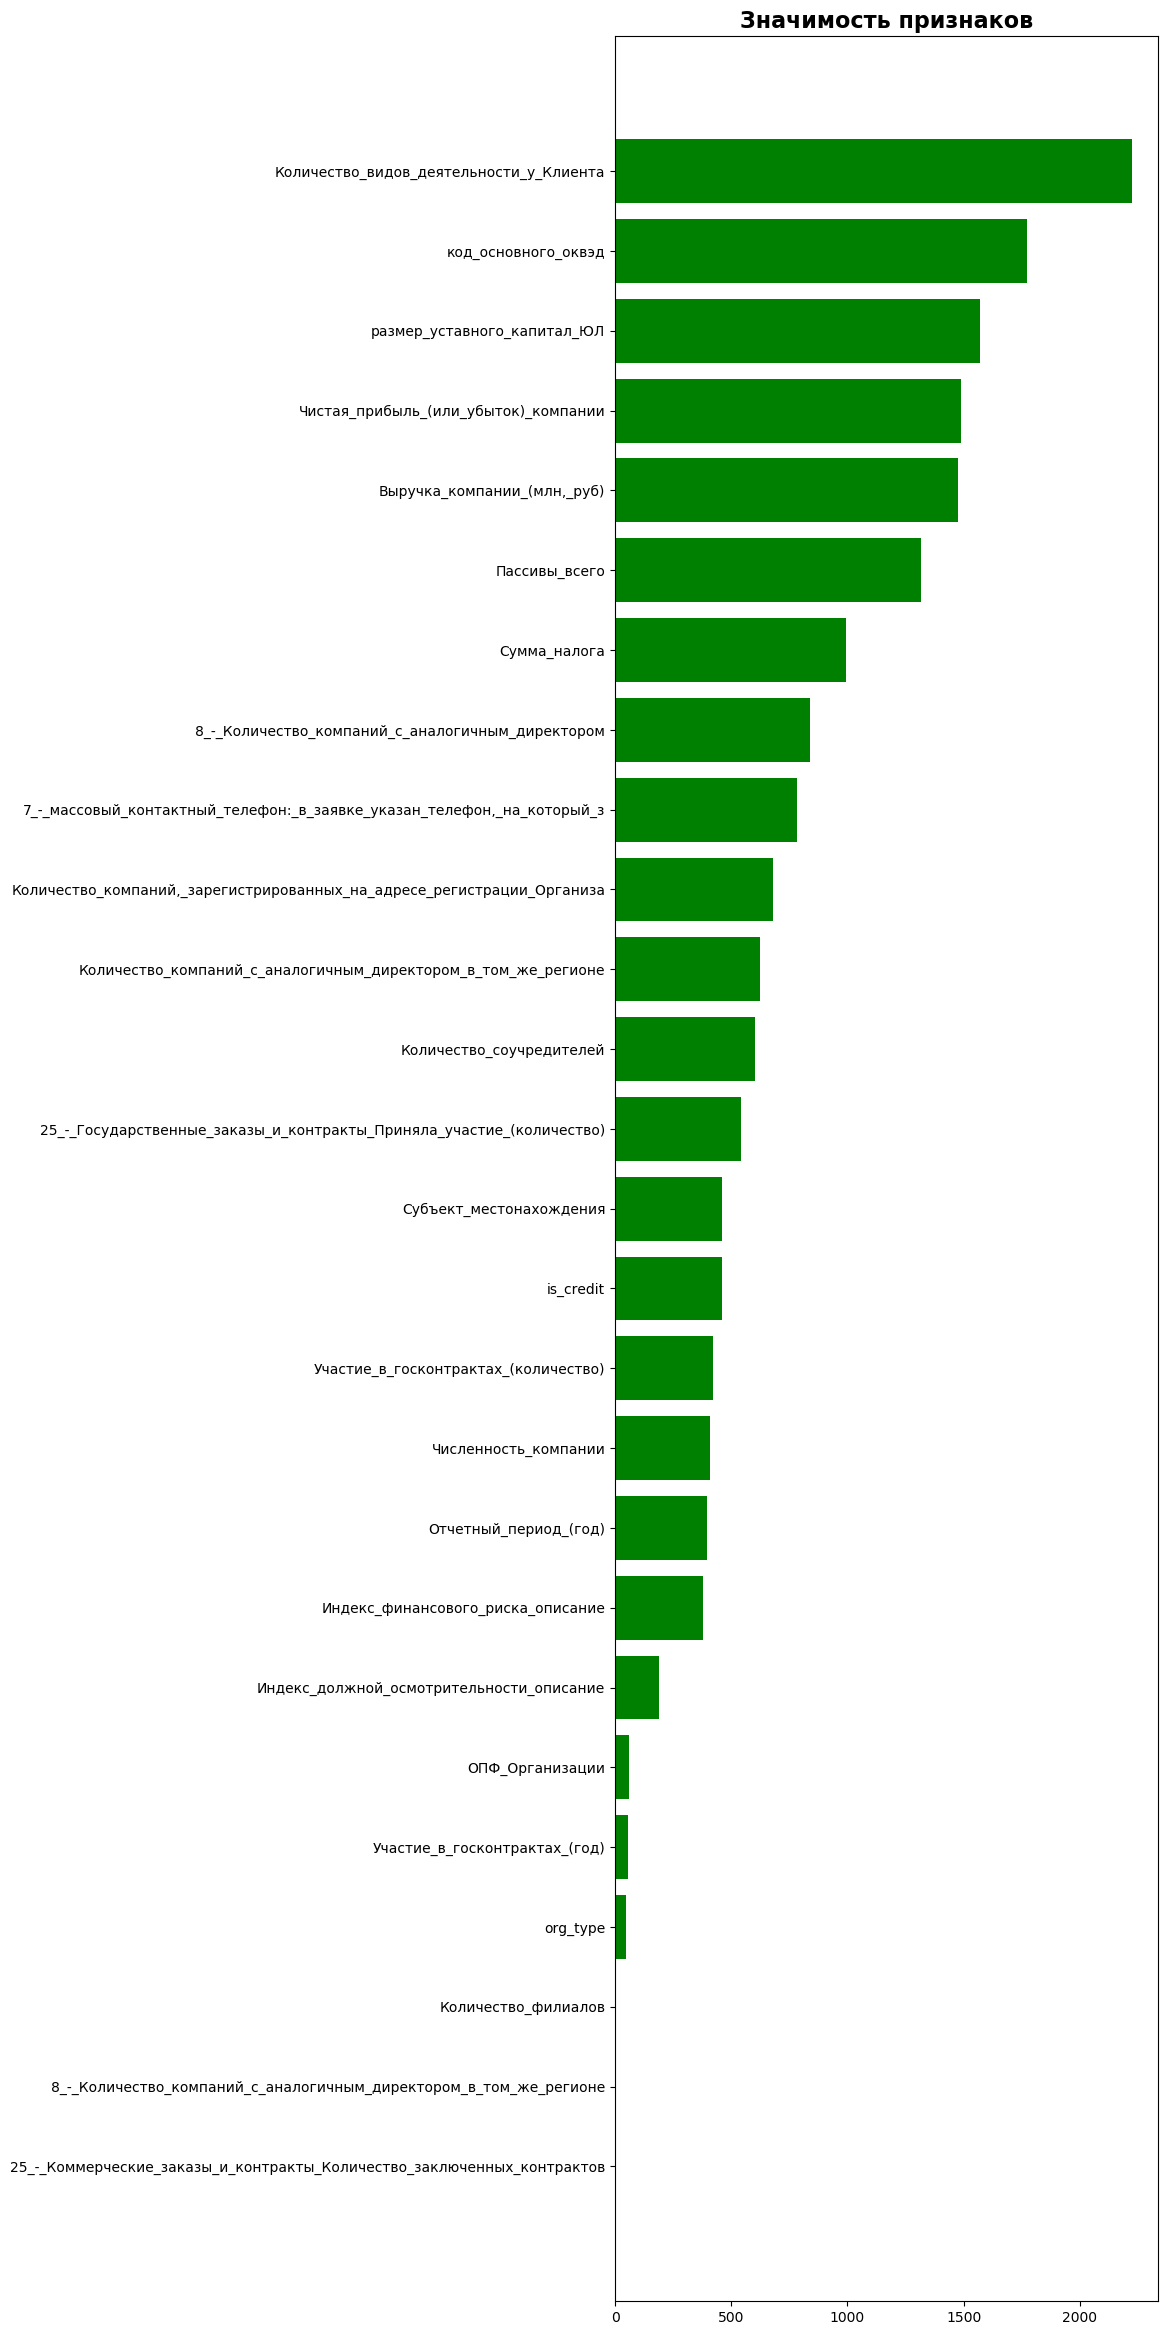

In [211]:
dset = pd.Series(model.feature_importance(importance_type='split'), 
                       index=[col[:70] for col in model.feature_name()])\
                      .sort_values(ascending=True)

plt.figure(figsize=(7, 30), dpi=100)
plt.barh(y=dset.index, width=dset, color='g')
plt.title('Значимость признаков', fontsize=16, fontweight='bold')
plt.show()
                 
                
#=[col[:70] for col in model.feature_name()]

## Сохранение модели

In [270]:
#pickle.dump(model, open('lgbm_model.pkl', 'wb'))


joblib.dump(model, 'lgbm_model.pkl')


['lgbm_model.pkl']